## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B test run by an e-commerce website to understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Lets import libraries.

In [83]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Reading the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [84]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [85]:
row_count = df.shape[0]
row_count

294478

c. The number of unique users in the dataset.

In [86]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [87]:
df['converted'].value_counts()

0    259241
1     35237
Name: converted, dtype: int64

In [88]:
35237/df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [89]:
df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page'))].count() + df[((df['group'] == 'control') & (df['landing_page'] != 'old_page'))].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [90]:
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

In [91]:
treatment_newpage_mismatch = 1928+1965
treatment_newpage_mismatch

3893

f. Do any of the rows have missing values?

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Store new dataframe in **df2**.

In [93]:
mismtach_names1 = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index
mismtach_names2 = df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].index
df2 = df.drop(mismtach_names1)
df2 = df2.drop(mismtach_names2)

In [94]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** 

a. How many unique **user_id**s are in **df2**?

In [95]:
df2['user_id'].count()

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [96]:
repeated_userid = df2[df2['user_id'].duplicated()]
repeated_userid.values

array([[773192, '2017-01-14 02:55:59.590927', 'treatment', 'new_page', 0]], dtype=object)

c. What is the row information for the repeat **user_id**? 

In [97]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [98]:
df2 = df2.drop(1899)
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [99]:
(df2['converted']==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [100]:
control_converted = df2.query('group =="control"')['converted'].mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [102]:
treatment_converted = df2.query('group =="treatment"')['converted'].mean()
treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [103]:
newpage_prob = (df2['landing_page']=="new_page").mean()
newpage_prob

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

Based on the results, it is seen that only 11.2% people converted into the program. 
The chance of conversion in control group and treatment group is almost the same i.e., around 12% and 11.8%.
So, there is not enough evidence to conclude that the new page is leading to higher number of conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H$_0$ : P$_{old}$ $\ge$ P$_{new}$ <br>
H$_1$ : P$_{old}$ < P$_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [105]:
P_new = df2['converted'].mean()
P_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [107]:
P_old = df2['converted'].mean()
P_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [108]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [109]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [110]:
new_page_converted = df2.query('group == "treatment"')
new_null_vals = new_page_converted.query('converted == 1')['user_id'].nunique()/new_page_converted.query('converted == 0')['user_id'].nunique()
new_null_vals

0.13482654670977617

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [111]:
old_page_converted = df2.query('group == "control"')
old_null_vals = old_page_converted.query('converted == 1')['user_id'].nunique()/old_page_converted.query('converted == 0')['user_id'].nunique()
old_null_vals

0.13686269906483547

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [112]:
obs_diff = new_null_vals - old_null_vals
obs_diff

-0.002036152355059301

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [38]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
    sample_df = df2.sample(size,replace=True)
    control_df = sample_df.query('group == "control"')
    treatment_df = sample_df.query('group == "treatment"')
    control_mean = control_df.query('converted == 1')['user_id'].nunique()/control_df.query('converted == 0')['user_id'].nunique()
    treatment_mean = treatment_df.query('converted == 1')['user_id'].nunique()/treatment_df.query('converted == 0')['user_id'].nunique()
    p_diffs.append(treatment_mean - control_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

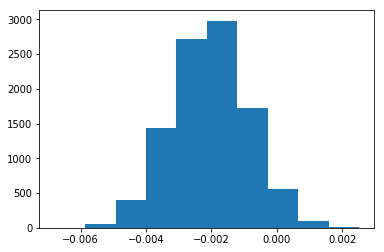

In [40]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [50]:
(p_diffs > obs_diff).mean()

0.50339999999999996

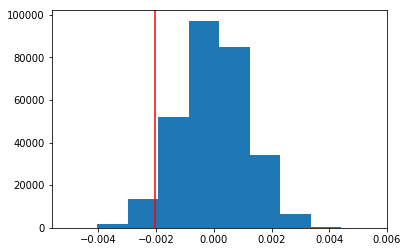

In [51]:
null_vals = np.random.normal(0,p_diffs.std(),size)
plt.hist(null_vals);
plt.axvline(obs_diff,color='r');

In [52]:
(null_vals > obs_diff).mean()

0.95782630839963656

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

0.957 is called as the p-value in scientific studies. Based on the result, it can be said that the p-value > .05 (Type 1 error rate) and hence we fail to reject the Null Hypothesis which states that old page is better than the new page.
Also, the observed diference falls within the plot which indicates that the result follows the Null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [113]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')
convert_new = df2.query('group == "treatment"')
n_old = convert_old.shape[0]
n_new = convert_new.shape[0]

In [114]:
success_count = df2.query('converted == 1')['user_id'].nunique()
success_count

34753

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [115]:
stats,pval = sm.stats.proportions_ztest(success_count,df2.shape[0],.05)
stats,pval

(115.61811279026708, 0.0)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Based on the result, it is seen that statistics is high and the p-value is 0, which indicates that it is statistically significant to move to the new page inorder to get more conversions.
This result does not agree with the finding s of parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [116]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [117]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [118]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-13 06:38 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The p-value associated with ab_page is 0.1899. This differs from the p-value found in Part 2, since Logistic regression predicts the log odds and not the response.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Other factors that might influence whether an individual will convert or not is the time duration. It is shown below that the time range for which the prediction is based on is very small i.e., less than a month.
It would be helpful to monitor individual behavior over a longer range of period, which would give us more idea based on consistent usage of individuals.

In [64]:
(df2['timestamp'].min(),df2['timestamp'].max())

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [119]:
country_df = pd.read_csv('countries.csv')
country_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [120]:
df2 = df2.join(country_df.set_index('user_id'),on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [121]:
dummy_country = pd.get_dummies(df2['country'])
df_new = df2.join(dummy_country)
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [122]:
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
res = lm.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-13 06:39 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

It is seen that p-value for the countries as well as ab_page is higher than .05. Hence it does not seem to be statistically significant to get conversion from new page.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [123]:
df_new['ab_CA'] = df_new['ab_page']*df_new['CA']
df_new['ab_UK'] = df_new['ab_page']*df_new['UK']
df_new['ab_US'] = df_new['ab_page']*df_new['US']
lm = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK','ab_CA','ab_UK','ab_US']])
res = lm.fit()
res.summary2()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                 Logit              No. Iterations:     6.0000     
Dependent Variable:    converted          Pseudo R-squared:   0.000      
Date:                  2020-08-13 06:39   AIC:                212782.6602
No. Observations:      290584             BIC:                212846.1381
Df Model:              5                  Log-Likelihood:     -1.0639e+05
Df Residuals:          290578             LL-Null:            -1.0639e+05
Converged:             1.0000             Scale:              1.0000     
-------------------------------------------------------------------------
           Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------
intercept -1.9865      0.0096 -206.3440 0.0000       -2.0053      -1.9676
ab_page   -0.0193 704237.3061   -0.0000 1.0000 -1380279.7759 1380279.7373
CA        -0.0175      0.0377   -0.4652 0.6418       -0.0914       0.0563
UK        -0.0057      0.0188   -0.3057 0.7598       -0.0426       0.0311
ab_CA     -0.0482 704237.3061   -0.0000 1.0000 -1380279.8047 1380279.7084
ab_UK      0.0301 704237.3061    0.0000 1.0000 -1380279.7264 1380279.7867
ab_US     -0.0013 704237.3061   -0.0000 1.0000 -1380279.7578 1380279.7553
=========================================================================

"""

Based on the result, it is seen that the p-value is high for the higher order terms i.e., for the relationship between the pages and countries. So it does not have a significant value on indicating that based on country type the page conversion varies.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [124]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0